<html>
    <div style="padding: 50px; background-color: lightskyblue; text-align: center; color: #000;">
        <h1>CAB420 Workshop - Week 4 Practical</h1>
        <h2>Deep Learning</h2>
    </div>
</html>

In [60]:
# Loading in the required libraries
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical


# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy

In [61]:
# Function used to evaluate the model
def eval_model(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

Deep Neural Networks have exploded in popularity in recent years due to their impressive performance. For the most part, neural networks are very adaptable and a network that performs well on one task will perform similarly well on another similar task (here, we can consider both tasks being image classification to make them sufficiently similar), assuming that other factors such as dataset characteristics are similar. Given this, it is very common to see the same, or very similar architecture used over and over again. These architectures are typically based on large models that have performed well (or won) a popular image classification benchmark, the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

The first deep network to win the ILSVRC challenge was [AlexNet](https://proceedings.neurips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). The structure of AlexNet is shown in the prac sheet, and consists of:
* An input, of size $224 \times 224 \times 3$ (i.e. a 224 pixel wide, by 224 pixel high, colour image).
* A 2D Convolution layer with $96$ $11 \times 11$ sized filters, followed by max pooling layer that operates over a $4\times 4$ region.
* A 2D Convolution layer with $256$ $5 \times 5$ sized filters, followed by a max pooling layer.
* A 2D Convolution layer, with $384$ $3 \times 3$ size filters.
* A 2D Convolution layer, with $384$ $3 \times 3$ size filters.
* A 2D Convolution layer, with $256$ $3 \times 3$ size filters.
* A fully connected (or dense) layer with $4096$ units.
* A fully connected (or dense) layer with $4096$ units.
* An output fully connected (or dense) layer, with $1000$ units (for the $1000$ classes in ImageNet).

Using this network on the CIFAR-10 dataset is not practical, but we can adapt the AlexNet architecture to CIFAR-10. You are to create a network of a similar style AlexNet, but tailored for CIFAR-10. A suggested approach would be:
* Use three 2D convolution layers (with max pooling in between), with filters of decreasing size, but increasing in number in similar ratios to AlexNet (i.e. the first convolution layer has 8 $7\times 7$ filters, the second has 24 $5\times 5$ filters, the third has 32 $3 \times 3$ filters). Use $4\times 4$ max pooling after the first layer, and $2\times 2$ after the second.
* Use two dense (fully connected) layers, one with $512$ units after the convolution layers, and then a final classification layer with $10$ units (i.e. the number of output classes).
* Use relu activations throughout, except for your output layer which should use a soft-max layer.

Train the network on the CIFAR-10 dataset, and evaluate the performance. When training the model, be sure to consider the dataset size ($50,000$ training samples) and batch size when selecting how many epochs to train for. Assuming you're using an optimiser such as Adam with default values, $\approx5000$ iterations will likely be sufficient to train your network to near convergence. After training, plot the training and validation losses and accuracies to observe if the model has converged, or is overfitting.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

### Suggested Packages

TensorFlow and Keras are your friends here. Matplotlib and maybe seaborn will be good for plotting, and sklearn also provides some useful functionality for confusion matricies and accuracy metrics.

## Loading the Data

CIFAR-10 is built into keras, so we can load that directly. Note that we will:
* Convert the y-data to categoricals
* Plot some example images as a sanity check

In [62]:
# Loading data using the keras API
(train, train_y), (test, test_y) = keras.datasets.cifar10.load_data()

# converting the y data to one hot encoding
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

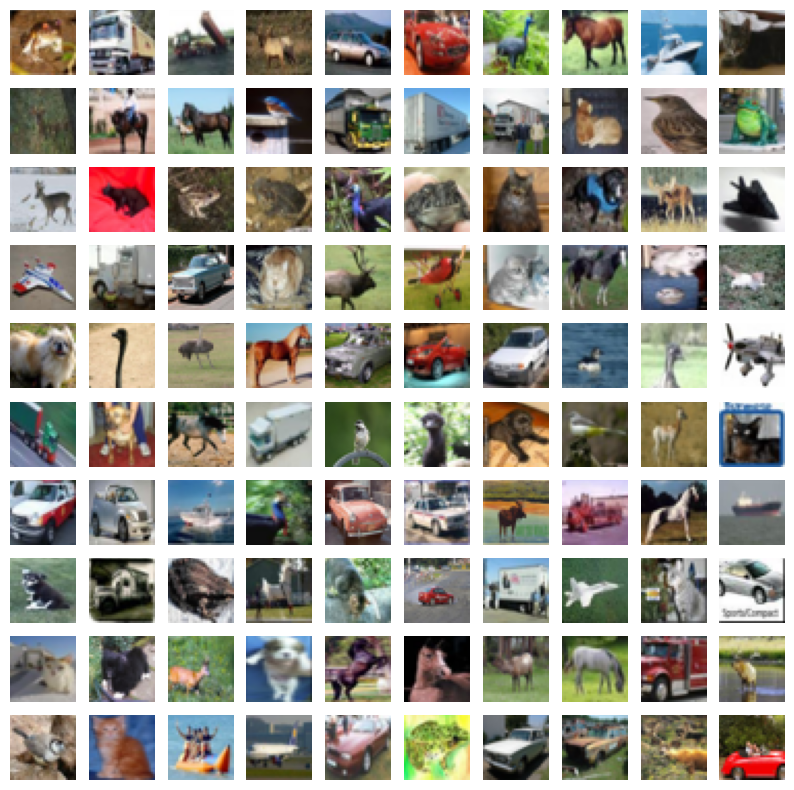

In [63]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,:])
    ax.axis('off')

## Building the network

In [64]:
input = keras.Input(shape=(32, 32, 3), name = 'img')

conv2d_layer_one = layers.Conv2D(8, (7, 7), activation='relu', padding='same')(input)
max_pooling_layer_one = layers.MaxPooling2D((4, 4), padding='same')(conv2d_layer_one)
conv2d_layer_two = layers.Conv2D(24, (5, 5), activation='relu', padding='same')(max_pooling_layer_one)
max_pooling_layer_two = layers.MaxPooling2D((2, 2), padding='same')(conv2d_layer_two)
conv2d_layer_three = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(max_pooling_layer_two)

flatten_layer = layers.Flatten()(conv2d_layer_three)

dense_layer_one = layers.Dense(512, activation='relu')(flatten_layer)
output = layers.Dense(10, activation='softmax')(dense_layer_one)

model = keras.Model(inputs=input, outputs=output)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 8)      │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 8, 8, 24)       │         4,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 4, 4, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 4, 4, 32)       │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,738 (1.07 MB)

 Trainable params: 280,738 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

## Training the network

In [65]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history = model.fit(train, train_y, epochs=5, batch_size=32, 
                    validation_data=(test, test_y))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.3163 - loss: 2.2647 - val_accuracy: 0.4228 - val_loss: 1.6299
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4523 - loss: 1.5209 - val_accuracy: 0.4566 - val_loss: 1.5355
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4980 - loss: 1.4113 - val_accuracy: 0.4858 - val_loss: 1.4499
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5235 - loss: 1.3382 - val_accuracy: 0.5186 - val_loss: 1.3896
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5497 - loss: 1.2799 - val_accuracy: 0.5167 - val_loss: 1.3954


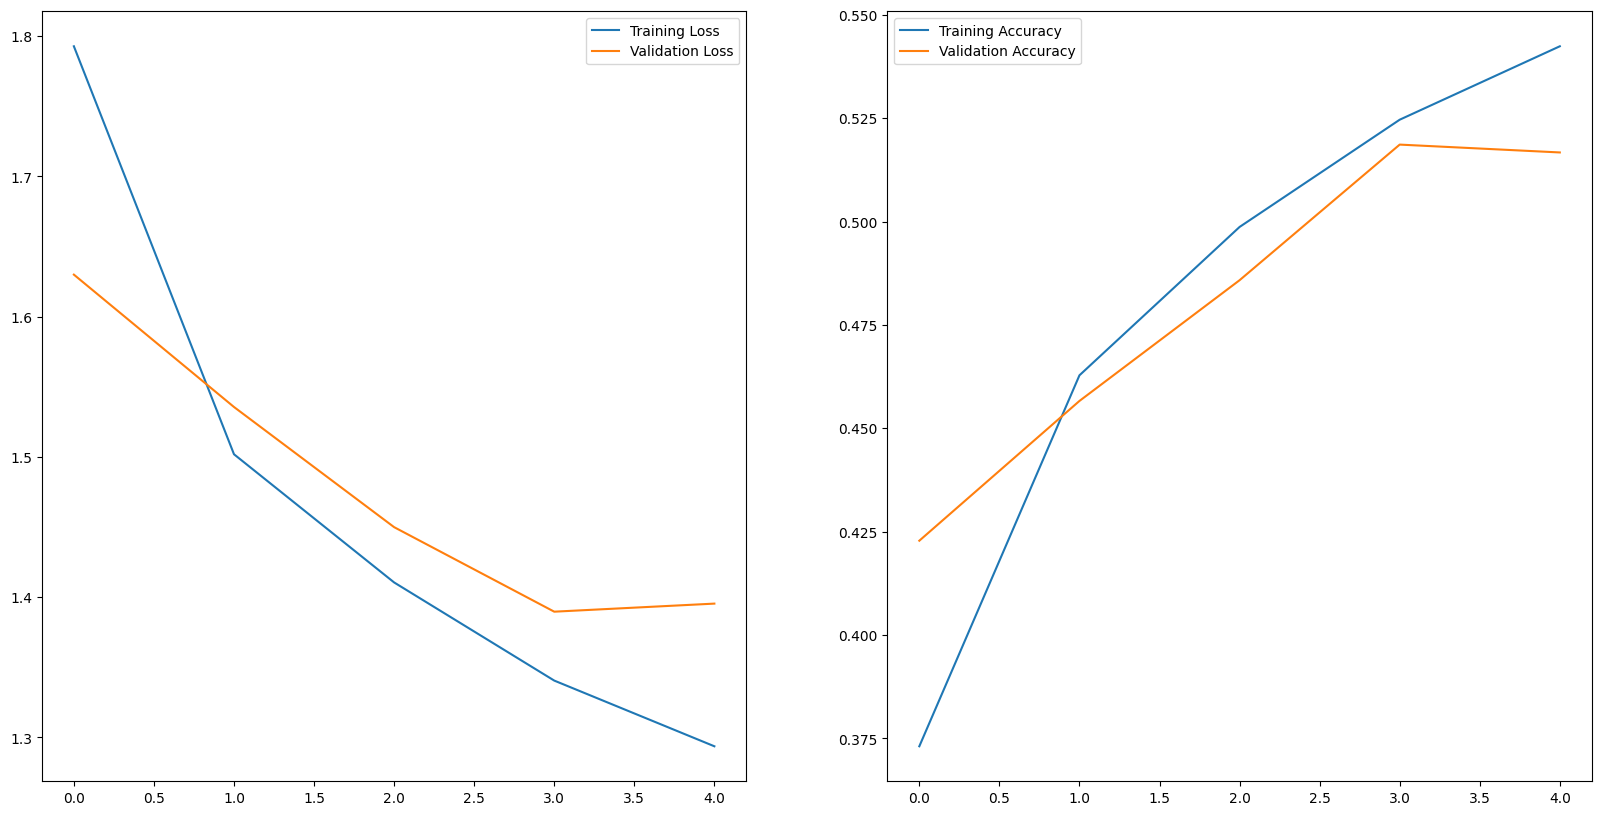

In [66]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

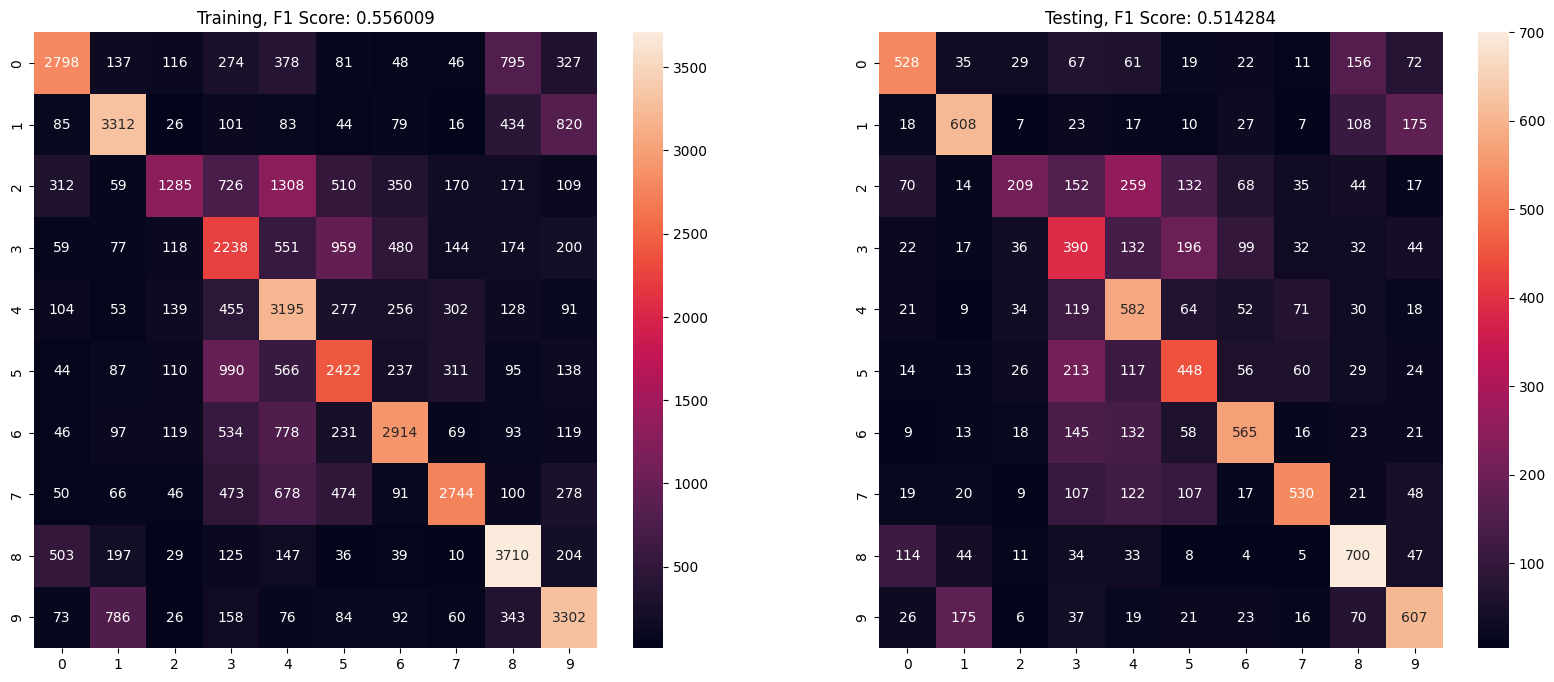

In [67]:
# Evaluate the model
eval_model(model, train, train_y, test, test_y)

# Problem 2
## Implementing a VGG-Like Network

While AlexNet was the first deep convolutional neural network to get widespread attention, it's performance has since been superseded by many other methods. One such method is [VGG](https://arxiv.org/abs/1409.1556), which is illustrated in the prac sheet.

VGG-16 (and it's slightly larger brother, VGG-19) makes use of smaller, stacked convolution operations. Where AlexNet used large convolution kernels early in the network (the first layer used a $11\times 11$ kernel, VGG-16 uses only $3\times 3$ kernels, yet stacks these in pairs, or sets of three (or sets of four in VGG-19). 

Using the diagrams in the prac sheet as a guide, implement a deep convolution neural network to operate on CIFAR-10 that is inspired by VGG-16. A suggested approach would be:
* A pair of 2D Convolution layers (with an activation between), each with $8$ $3\times 3$ filters, followed by a max pooling layer.
* A pair of 2D Convolution layers (with an activation between), each with $16$ $3\times 3$ filters, followed by a max pooling layer.
* A pair of 2D Convolution layers (with an activation between), each with $32$ $3\times 3$ filters, followed by a max pooling layer.
* Two dense (fully connected) layers, one with $512$ units after the convolution layers, and then a final classification layer with $10$ units.
* Use relu activations throughout, except for your output layer which should use a soft-max layer.

Train and evaluate the network on CIFAR-10, and compare the performance to the earlier trained AlexNet style network. When comparing the networks, also consider the number of parameters in each network, how long the two networks took to train and evaluate, and what was observed with respect to model convergence and overfitting.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

You should also see a lot of similarities between your solution to Question 1 and this question, with the only noteworthy difference being the different network.

### Suggested Packages

TensorFlow and Keras are your friends here. Matplotlib and maybe seaborn will be good for plotting, and sklearn also provides some useful functionality for confusion matricies and accuracy metrics.

## Building The Network

In [68]:
input_vgg = keras.Input(shape = (32, 32, 3, ), name = 'img_vgg')

conv2d_layer_one = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_vgg)
activation_layer_one = layers.Activation('relu')(conv2d_layer_one)
conv2d_layer_two = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(activation_layer_one)
max_pooling_layer_one = layers.MaxPooling2D((2, 2), padding='same')(conv2d_layer_two)

conv2d_layer_three = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(max_pooling_layer_one)
activation_layer_two = layers.Activation('relu')(conv2d_layer_three)
conv2d_layer_four = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(activation_layer_two)
max_pooling_layer_two = layers.MaxPooling2D((2, 2), padding='same')(conv2d_layer_four)

dense_layer_one = layers.Dense(512, activation='relu')(layers.Flatten()(max_pooling_layer_two))
output = layers.Dense(10, activation='softmax')(dense_layer_one)

model_vgg = keras.Model(inputs=input_vgg, outputs=output, name = 'vgg_model')
model_vgg.summary()

Model: "vgg_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_vgg (InputLayer)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,874 (4.09 MB)

 Trainable params: 1,070,874 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model_vgg.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history_vgg = model_vgg.fit(train, train_y, epochs=5, batch_size=32,
                            validation_data=(test, test_y))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3875 - loss: 3.3420 - val_accuracy: 0.5619 - val_loss: 1.2215
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.6038 - loss: 1.1176 - val_accuracy: 0.6061 - val_loss: 1.1389
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.6812 - loss: 0.9018 - val_accuracy: 0.6304 - val_loss: 1.0877
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7387 - loss: 0.7470 - val_accuracy: 0.6575 - val_loss: 1.0291
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7936 - loss: 0.5934 - val_accuracy: 0.6409 - val_loss: 1.1525


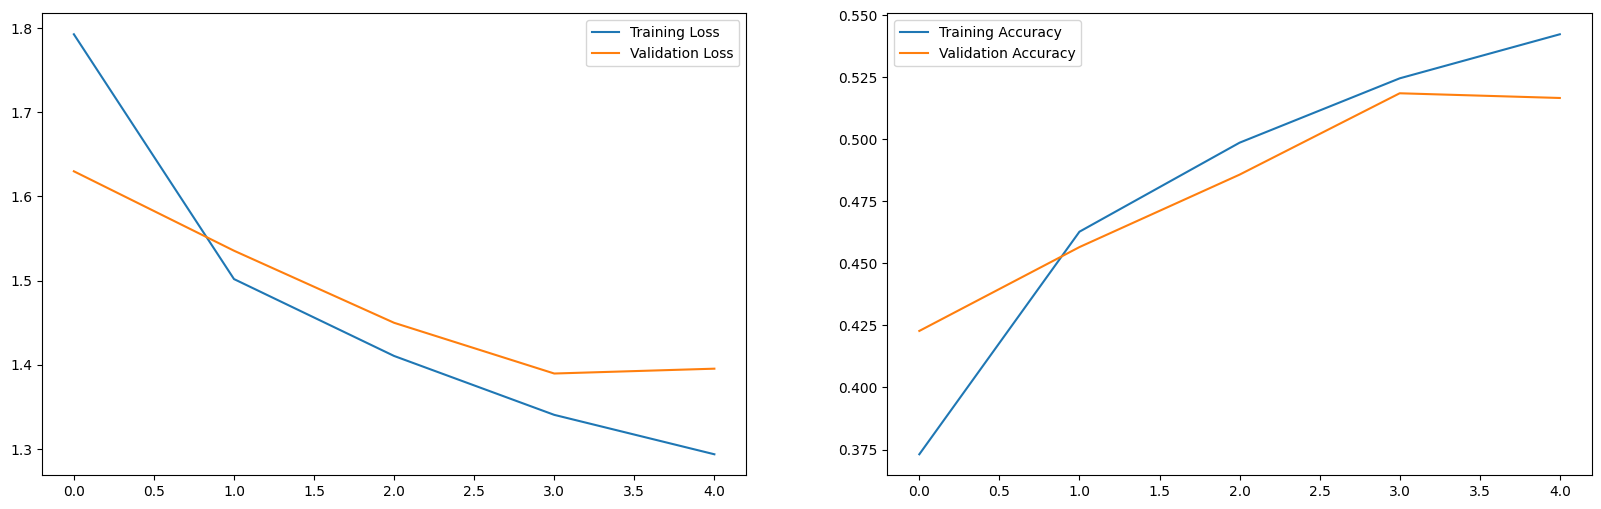

In [70]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

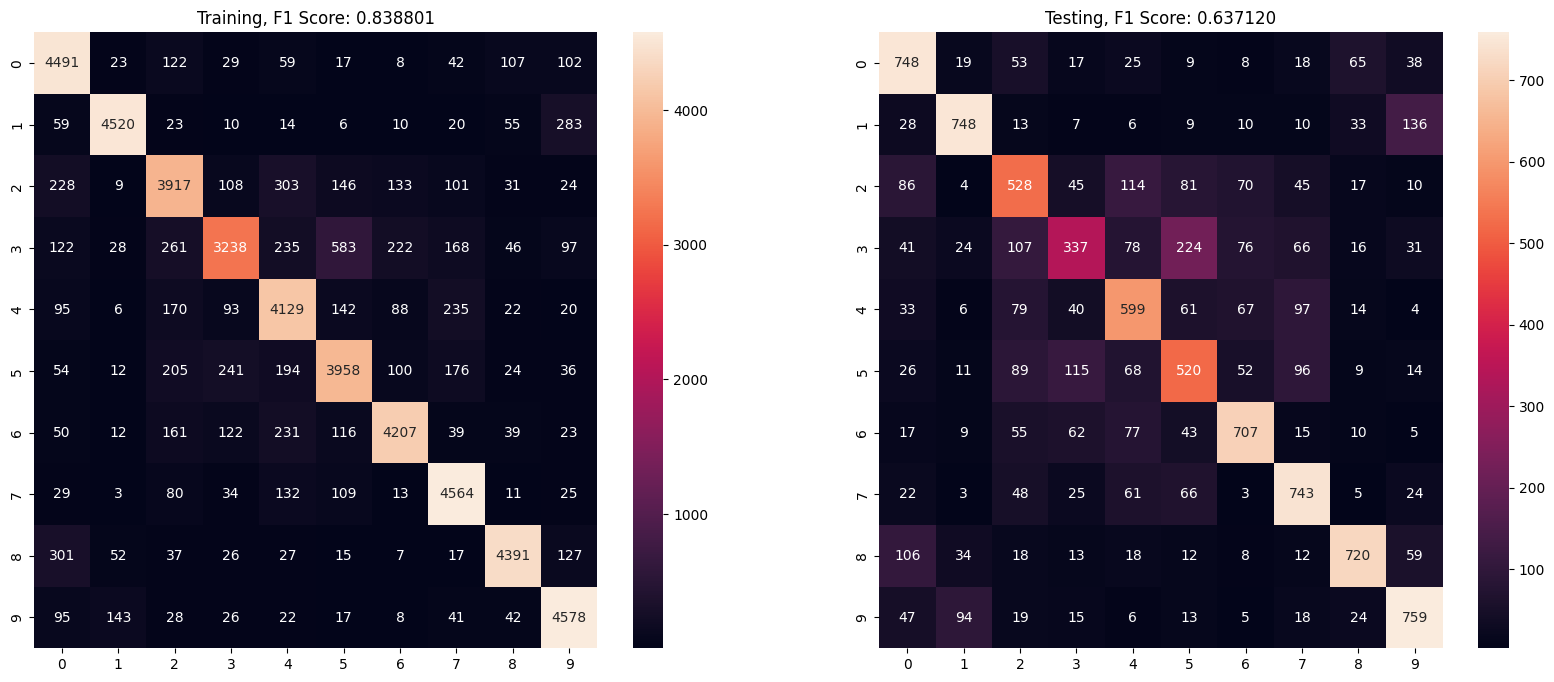

In [71]:
eval_model(model_vgg, train, train_y, test, test_y)

## Exploring Other Layers

There are many changes or extensions that you could make to the above networks to further explore deep convolutional neural networks. In your own time, try the following:
* Add dropout to one (or both) networks in a few locations. Use ``SpatialDropout2D`` layers after convolution layers, and ``Dropout`` layers after dense layers. With dropout layers in the network, consider:
  * How is the number of iterations required to train the network to convergence impacted by the addition of dropout?
  * Are any differences with respect to overfitting observed?
  * What happens as the dropout probability is increased?
* Add Batch Normalisation to the network in a few locations. With batch normalisation in the network, consider:
  * How is the number of iterations required to train the network to convergence impacted by the addition of batch normalisation?
  * Are any differences with respect to overfitting observed?
* Change the ``padding`` type used by the convolutional layers. Observe what happens to the representation size when you change this.
* Change the activation used. Consider using an activation such as Swish, or an ELU, rather than the standard relu (though leave the final activation as a softmax). Train the network with the alternate activation and note any changes.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

The additional example, ``CAB420_DCNNs_Additional_Example_4_Layer_Order_and_Overfitting.ipynb`` is also worth a look as it shows how to use layers like dropout and batchnorm.

Finally, this question should build directly of your answers to Q1 and Q2 as well.

## Copying the VGG model from before and incorporating a dropout

In [72]:
input_prob3_vgg = keras.Input(shape = (32, 32, 3, ), name = 'img_vgg')

conv2d_layer_one = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_prob3_vgg)
activation_layer_one = layers.Activation('relu')(conv2d_layer_one)
conv2d_layer_two = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(activation_layer_one)
dropout_layer_one = layers.SpatialDropout2D(0.2)(conv2d_layer_two)
max_pooling_layer_one = layers.MaxPooling2D((2, 2), padding='same')(dropout_layer_one)

conv2d_layer_three = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(max_pooling_layer_one)
activation_layer_two = layers.Activation('relu')(conv2d_layer_three)
conv2d_layer_four = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(activation_layer_two)
dropout_layer_two = layers.SpatialDropout2D(0.2)(conv2d_layer_four)
max_pooling_layer_two = layers.MaxPooling2D((2, 2), padding='same')(conv2d_layer_four)

dense_layer_one = layers.Dense(512, activation='relu')(layers.Flatten()(max_pooling_layer_two))
dropout_layer_three = layers.Dropout(0.5)(dense_layer_one)
output = layers.Dense(10, activation='softmax')(dropout_layer_three)

model_prob3_vgg = keras.Model(inputs=input_prob3_vgg, outputs=output, name = 'vgg_model_prob3')
model_prob3_vgg.summary()

Model: "vgg_model_prob3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_vgg (InputLayer)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 32, 32, 16)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,874 (4.09 MB)

 Trainable params: 1,070,874 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model_prob3_vgg.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history_vgg = model_prob3_vgg.fit(train, train_y, epochs=5, batch_size=32,
                            validation_data=(test, test_y))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.2941 - loss: 3.3170 - val_accuracy: 0.4889 - val_loss: 1.4805
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.4736 - loss: 1.4688 - val_accuracy: 0.5382 - val_loss: 1.3060
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.5252 - loss: 1.3351 - val_accuracy: 0.5963 - val_loss: 1.1485
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5610 - loss: 1.2356 - val_accuracy: 0.6106 - val_loss: 1.0943
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5904 - loss: 1.1639 - val_accuracy: 0.6233 - val_loss: 1.0659


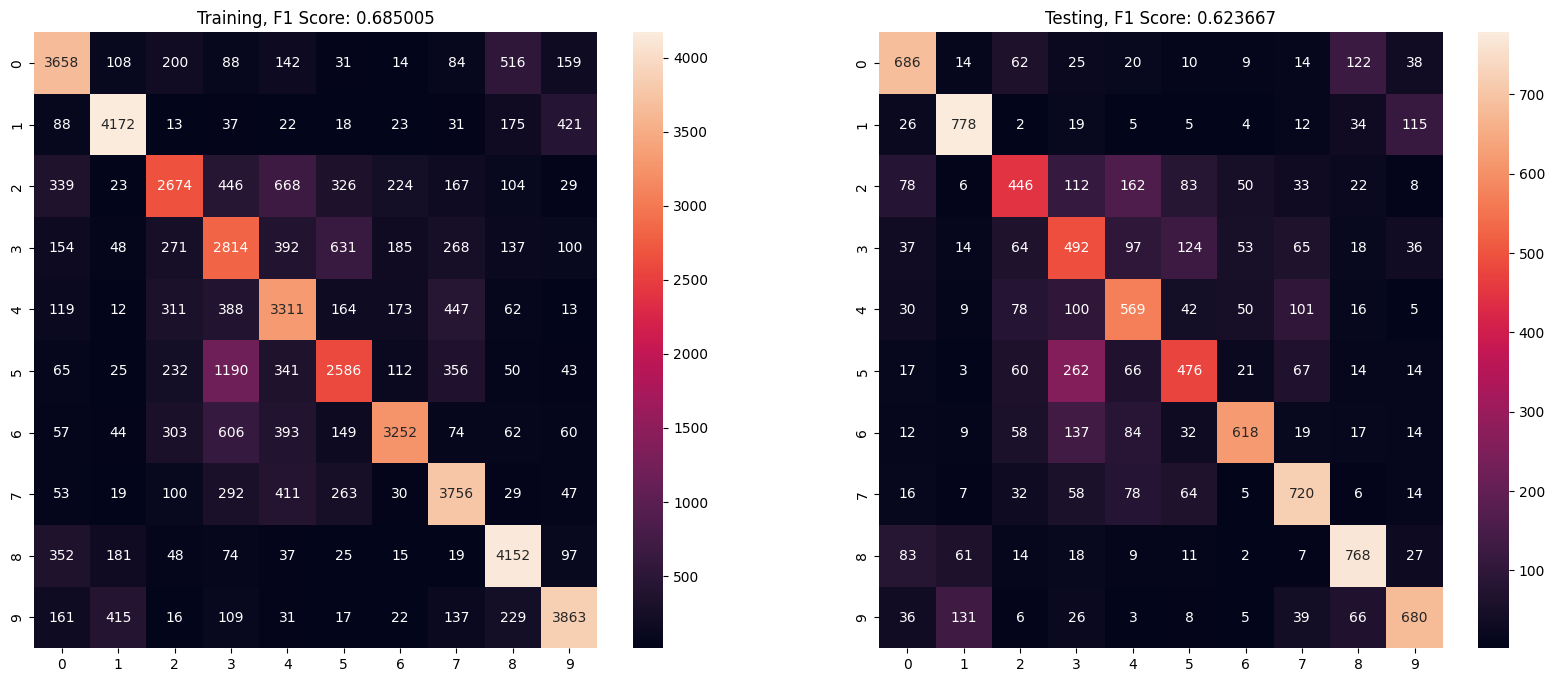

In [74]:
eval_model(model_prob3_vgg, train, train_y, test, test_y)